# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase1.ipynb or .zip </h5>
</div>

Setting up the environment

In [20]:
%pip install pyrosm keplergl haversine pandas numpy


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [217]:
%pip install geopy shapely pyproj tqdm haversine


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time

from keplergl import KeplerGl
from pyrosm import OSM, get_data

In [2]:
# If you are using colab, you need to run this cell
from google.colab import output
output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'google'

## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/path_map.png" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [3]:
# Load the data
pasdaran_streets = pd.read_csv('./pasdaran_streets.csv')
pasdaran_nodes = pd.read_csv('./pasdaran_nodes.csv', index_col='id')

In [4]:
pasdaran_streets.head()

street_id           u          v   length oneway      u_lat      u_lon  \
0    5003747   423833948  423793584   90.570     no  35.772419  51.465652   
1   17099043   177540293  423832815  296.273    yes  35.771034  51.464462   
2  787945693  4429684144  423832815   62.573     no  35.772636  51.461891   
3  687277053   177540293  423793585   97.898     no  35.771034  51.464462   
4   36333153  9339973930  423793585  296.275    yes  35.771458  51.460865   

       v_lat      v_lon  
0  35.771748  51.465084  
1  35.772175  51.461494  
2  35.772175  51.461494  
3  35.770317  51.463833  
4  35.770317  51.463833

In [5]:
pasdaran_nodes.head()

lat        lon
id                             
423833948  35.772419  51.465652
423793584  35.771748  51.465084
177536927  35.776230  51.465034
177540293  35.771034  51.464462
423832815  35.772175  51.461494

In [26]:
pasdaran_streets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street_id  1831 non-null   int64  
 1   u          1831 non-null   int64  
 2   v          1831 non-null   int64  
 3   length     1831 non-null   float64
 4   oneway     1831 non-null   object 
 5   u_lat      1831 non-null   float64
 6   u_lon      1831 non-null   float64
 7   v_lat      1831 non-null   float64
 8   v_lon      1831 non-null   float64
dtypes: float64(5), int64(3), object(1)
memory usage: 128.9+ KB


# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [27]:
from dataclasses import dataclass
from queue import PriorityQueue
import pandas as pd
import numpy as np

def degree_to_radian(deg):
    return deg * np.pi / 180.0

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6_378_137.0

    lat1_rad = degree_to_radian(lat1)
    lon1_rad = degree_to_radian(lon1)
    lat2_rad = degree_to_radian(lat2)
    lon2_rad = degree_to_radian(lon2)

    d_lat= lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    a = np.sin(d_lat / 2)**2 + np.sin(d_lon / 2)**2 * np.cos(lat1_rad) * np.cos(lat2_rad) 
    return radius * 2 * np.arcsin(np.sqrt(a))

@dataclass
class Neighbour:
    key: np.int64 #id
    length: np.float64 # street length
    lat: np.float64
    lon: np.float64
    
    def get_distance(self, lat, lon):
        return haversine_distance(lat, lon, self.lat, self.lon)
    
def get_neighbours(node, graph: pd.DataFrame):
    res = []
    rows = graph[(graph['u'] == node) | ((graph['v'] == node) & (graph['oneway'] == 'no'))].iterrows()
    for _, row in rows:
        u = 'u'
        if row['u'] == node:
            u = 'v'
        
        res.append(Neighbour(key=row[u], length=row['length'], lat=row[f"{u}_lat"], lon=row[f"{u}_lon"]))
    return res

def get_node_id(lat, lon, graph: pd.DataFrame):
    tmp = graph[(graph['v_lat'] == lat) & (graph['v_lon'] == lon)]
    if len(tmp) > 0:
        return tmp.iloc[0]['v']

    tmp = graph[(graph['u_lat'] == lat) & (graph['u_lon'] == lon)]
    if len(tmp) == 0:
        return None

    return tmp.iloc[0]['u']

def get_path(last_node, first_node, parents):
    res = [last_node]
    while last_node != first_node:
        last_node = parents[last_node]
        res.append(last_node)
    
    return list(reversed(res))

def find_shotest_path(start_node, end_node, graph: pd.DataFrame):
    start_id = get_node_id(*start_node, graph)
    end_id = get_node_id(*end_node, graph)
    
    start_end_distance = haversine_distance(*start_node, *end_node)
    
    g_score = dict()
    parents = dict()
    queue = PriorityQueue()
    
    # f_score, -g_score, node
    queue.put((start_end_distance, 0, start_id))
    g_score[start_id] = 0
    
    while not queue.empty():
        node_f_score, tmp, node = queue.get()
        node_g_score = -tmp
        if node_g_score > g_score[node]:
            continue
        
        if node == end_id: 
            return get_path(end_id, start_id, parents)
        
        neighbours = get_neighbours(node, graph)
        for neighbour in neighbours:
            nei_h_score = neighbour.get_distance(*end_node)
            nei_g_score = node_g_score + neighbour.length
            nei_f_score = nei_g_score + nei_h_score
            nei_node = neighbour.key
            if nei_node in g_score and g_score[nei_node] < nei_g_score:
                continue
            g_score[nei_node] = nei_g_score
            parents[nei_node] = node
            queue.put((nei_f_score, -nei_g_score, nei_node))
            
    return None

You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [28]:
start_node, end_node = [(row['lat'], row['lon']) for _, row in pasdaran_nodes.sample(2, replace=False).iterrows()]

path = find_shotest_path(start_node, end_node, pasdaran_streets)

path

[4696632871,
 4696627041,
 4696632869,
 4696632868,
 4696632867,
 423832941,
 423832817,
 423832942,
 4482481112,
 423832943,
 4429692923,
 4429692926,
 4429692927,
 4698557148,
 423832810,
 423793664,
 6096557786,
 10922701618,
 10922701619,
 10922701617,
 6096557785,
 423793624,
 1707151175,
 806589258,
 4316456854,
 4316456855,
 4316456857,
 4695975712,
 1721683038,
 4695987410,
 1721683025,
 4695975717,
 4695975719,
 4316456852,
 4316456856,
 423815691,
 423815692,
 4698536184,
 423815694,
 423815693,
 5667400230,
 5667400228,
 423813744,
 1725215788,
 5371311600,
 6112621133,
 30772668,
 355617111,
 5481054973,
 423813737,
 3798184980,
 5371311601,
 423813740,
 423821169,
 423813738,
 4493669609,
 1725215771,
 4493669605,
 423813739,
 423821086,
 4513930720,
 4513930722,
 4698502275,
 4493669625,
 423821054]

Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you 
can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [29]:

BASE_DATETIME = datetime.datetime(2024, 1, 8, 13, 12, 55, 237689)
LAMBDA = 5
def create_kepler_timestamps(row: pd.Series):
    return (BASE_DATETIME + datetime.timedelta(hours=LAMBDA * row.name)).strftime('%Y-%m-%d %H:%M')
    
    
path_nodes: pd.DataFrame = pasdaran_nodes.loc[path].copy()

path_nodes.rename(columns={
    'lat': 'Latitude',
    'lon': 'Longitude'
}, inplace=True)

path_nodes.reset_index(drop=True, inplace=True)

path_nodes['Time'] = path_nodes.apply(axis=1, func=create_kepler_timestamps)

In [30]:
path_nodes

Latitude  Longitude              Time
0   35.779083  51.464298  2024-01-08 13:12
1   35.779320  51.464272  2024-01-08 18:12
2   35.779282  51.463459  2024-01-08 23:12
3   35.778618  51.463570  2024-01-09 04:12
4   35.778423  51.463566  2024-01-09 09:12
..        ...        ...               ...
60  35.778950  51.444416  2024-01-21 01:12
61  35.778557  51.443928  2024-01-21 06:12
62  35.778214  51.443523  2024-01-21 11:12
63  35.777576  51.442772  2024-01-21 16:12
64  35.777519  51.442699  2024-01-21 21:12

[65 rows x 3 columns]

In [39]:
kepler_config={'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': ['data'],
     'id': 'nfq96k0uo',
     'name': ['Time'],
     'type': 'timeRange',
     'value': [1704719520000, 1705097760001],
     'enlarged': True,
     'plotType': 'histogram',
     'animationWindow': 'incremental',
     'yAxis': None,
     'speed': 1}],
   'layers': [{'id': 'r2x08tc',
     'type': 'point',
     'config': {'dataId': 'data',
      'label': 'Point',
      'color': [255, 203, 153],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-6',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#1a9850',
         '#91cf60',
         '#d9ef8b',
         '#fee08b',
         '#fc8d59',
         '#d73027'],
        'reversed': True},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Time', 'type': 'timestamp'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'data': [{'name': 'Latitude',
        'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Time', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 35.77482263195461,
   'longitude': 51.45950297368368,
   'pitch': 0,
   'zoom': 14.282947990422505,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}
path_map = KeplerGl(height=600, data={'data': path_nodes}, config=kepler_config)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [40]:
path_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['data'], 'id': 'nfq96k0uo', …

In [38]:
path_map.config

{'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': ['data'],
     'id': 'nfq96k0uo',
     'name': ['Time'],
     'type': 'timeRange',
     'value': [1704719520000, 1705097760001],
     'enlarged': True,
     'plotType': 'histogram',
     'animationWindow': 'incremental',
     'yAxis': None,
     'speed': 1}],
   'layers': [{'id': 'r2x08tc',
     'type': 'point',
     'config': {'dataId': 'data',
      'label': 'Point',
      'color': [255, 203, 153],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-6',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#1a9850',
         '#91cf60',
         '#d9ef8b',
         '#fee08b',
         '#fc8

In [13]:
path_map.save_to_html(file_name='path_map.html')

Map saved to path_map.html!


In [54]:
path

[4696632871,
 4696627041,
 4696632869,
 4696632868,
 4696632867,
 423832941,
 423832817,
 423832942,
 4482481112,
 423832943,
 4429692923,
 4429692926,
 4429692927,
 4698557148,
 423832810,
 423793664,
 6096557786,
 10922701618,
 10922701619,
 10922701617,
 6096557785,
 423793624,
 1707151175,
 806589258,
 4316456854,
 4316456855,
 4316456857,
 4695975712,
 1721683038,
 4695987410,
 1721683025,
 4695975717,
 4695975719,
 4316456852,
 4316456856,
 423815691,
 423815692,
 4698536184,
 423815694,
 423815693,
 5667400230,
 5667400228,
 423813744,
 1725215788,
 5371311600,
 6112621133,
 30772668,
 355617111,
 5481054973,
 423813737,
 3798184980,
 5371311601,
 423813740,
 423821169,
 423813738,
 4493669609,
 1725215771,
 4493669605,
 423813739,
 423821086,
 4513930720,
 4513930722,
 4698502275,
 4493669625,
 423821054]

In [56]:
path_loc = list(zip(path_nodes['Latitude'].tolist(),  path_nodes['Longitude'].tolist()))
path_loc[:5]

[(35.779083251953125, 51.464298248291016),
 (35.779319763183594, 51.46427154541016),
 (35.77928161621094, 51.46345901489258),
 (35.77861785888672, 51.46356964111328),
 (35.77842330932617, 51.463565826416016)]

Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

In [93]:
import math

def get_loc_by_node_id(node_id):
    return pasdaran_nodes.loc[node_id]['lat'], pasdaran_nodes.loc[node_id]['lon']

def visualize_a_ride(ride_speed, ride_gps_time, trip):
    res = []
    last_time_left_before_gps = 0
    for i in range(1, len(trip)):
        last_loc = get_loc_by_node_id(trip[i-1])
        this_loc = get_loc_by_node_id(trip[i])
        loc_distance = haversine_distance(*last_loc, *this_loc)
        time_in_road = loc_distance / ride_speed
        if time_in_road < last_time_left_before_gps:
            last_time_left_before_gps -= time_in_road
            continue
        cnt_gps = math.floor((time_in_road - last_time_left_before_gps) / ride_gps_time) + 1
        diff = (this_loc[0] - last_loc[0], this_loc[1] - last_loc[1])
        start_gps_loc = np.array(last_loc) + np.array(diff) * (last_time_left_before_gps / time_in_road)
        start_gps_end_road_diff = np.array(this_loc) - start_gps_loc
        
        for j in range(cnt_gps):
            res.append(tuple((start_gps_end_road_diff / cnt_gps * j + np.array(start_gps_loc)).tolist()))
        last_time_left_before_gps = (ride_gps_time - (time_in_road - (last_time_left_before_gps + (cnt_gps-1) * ride_gps_time)))
        print(last_time_left_before_gps)
    return res   
        

See a sample ride, printed out.

In [106]:
GPS_TIME = 15
RIDE_SPEED = 7

ride = visualize_a_ride(RIDE_SPEED, GPS_TIME, path)
ride

11.223068100757914
5.070996074710715
6.367499174313853
8.820534511707152
10.933066095488753
9.747606683769447
12.445002619016494
1.0134173551006658
12.592850757938962
9.535564992653821
10.439536190042272
10.981701990870514
11.717588994611607
11.004722993164243
11.734078408701215
10.215324591134525
12.193282619019444
10.678709633900034
12.853104465224328
14.242548107318852
8.317608917092617
14.53818136405195
14.393519852167396
14.510617366088868
13.856094812482004
10.858509291840955
11.741423674952433
14.814155613043825
10.042515293766009
3.4681367109050303


[(35.779083251953125, 51.464298248291016),
 (35.779236584867775, 51.46346652011644),
 (35.77837284540705, 51.463705846022606),
 (35.777757535508655, 51.464236012595535),
 (35.776862534560586, 51.46389340533519),
 (35.77599897144122, 51.46342599068365),
 (35.77596782247301, 51.462587433565886),
 (35.776240082955105, 51.461478569020684),
 (35.77645493058726, 51.460426615007),
 (35.77647919775452, 51.45988581643653),
 (35.777111716397336, 51.45922309048056),
 (35.77746407304502, 51.458144666660594),
 (35.77729757572363, 51.45735359814437),
 (35.77675227296923, 51.45712948156731),
 (35.77644592856874, 51.45604625281316),
 (35.776976511823136, 51.45551841757141),
 (35.77730092161366, 51.45442672767722),
 (35.776785033371105, 51.4538705871268),
 (35.77607034152279, 51.453425199396854),
 (35.77631806337522, 51.452592711056234),
 (35.776565785227646, 51.45176022271562),
 (35.77744556090811, 51.451207235565285),
 (35.778332738766665, 51.45160205357081),
 (35.778269362068414, 51.450526165177806)

In [107]:
def create_kepler_ride_by_loc(locs, time_coef):

    start_time = datetime.datetime(2024, 1, 8, 13, 12, 55, 237689)
    kepler_df = pd.DataFrame({
        'Latitude': [i[0] for i in locs],
        'Longitude': [i[1] for i in locs],
        'Time': [(start_time + datetime.timedelta(seconds=time_coef * i)).isoformat() for i in range(len(locs))]
    })
    
    return KeplerGl(height=800, data={'data': kepler_df}, config=kepler_config)
    
    

Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

In [108]:
create_kepler_ride_by_loc(ride, GPS_TIME)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['data'], 'id': 'nfq96k0uo', …

Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [109]:
def add_noise_to_coordinates(lat, lon, std_dev=10):
    radius = 6_378_137.0
    
    std_dev_lat = std_dev / (2 * radius * np.pi) * 360

    std_dev_lon = std_dev / (2 * np.pi * (radius  * np.cos(np.radians(lat)))) * 360
    
    noisy_lat = lat + np.random.normal(0, std_dev_lat)
    noisy_lon = lon + np.random.normal(0, std_dev_lon)
    
    return noisy_lat, noisy_lon

def add_gps_noise(ride, gps_noise_radius):
    res = []
    for loc in ride:
        res.append(add_noise_to_coordinates(*loc, gps_noise_radius))
    return res

In [110]:
GPS_NOISE = 10

noisy_ride = add_gps_noise(ride, GPS_NOISE)
noisy_ride

[(35.779200287839245, 51.46420691001013),
 (35.7791474699094, 51.46357462388906),
 (35.77841006894981, 51.46379283949454),
 (35.777794789166684, 51.46407148011675),
 (35.776890451358724, 51.46421857438802),
 (35.77583153211936, 51.46333209165996),
 (35.77622179626056, 51.46253359158762),
 (35.77637542432733, 51.46149144572711),
 (35.77668184268129, 51.4604313939877),
 (35.77655541620189, 51.459958781198495),
 (35.77710785156721, 51.45920132241257),
 (35.77758751829469, 51.45811843883692),
 (35.77729302540626, 51.457433782177915),
 (35.77670878747289, 51.45724917956793),
 (35.77649409555467, 51.45604991704488),
 (35.7770598621785, 51.45551464672685),
 (35.77721148067633, 51.45452316934837),
 (35.77680600457073, 51.453958554635626),
 (35.77600295250895, 51.453652986623965),
 (35.77616063032221, 51.45247587671451),
 (35.77664298871214, 51.4517427638833),
 (35.777409591832104, 51.45114015737376),
 (35.77829775322136, 51.45144275100757),
 (35.77846208853612, 51.45066568858953),
 (35.7781854

In [111]:

def create_kepler_compare_rides(time_coef, *args):
    
    start_time = datetime.datetime(2024, 1, 8, 13, 12, 55, 237689)
    data={}
    for idx, ride in enumerate(args):
        data[f"data_{idx}"] = pd.DataFrame({
            'Latitude': [i[0] for i in ride],
            'Longitude': [i[1] for i in ride],
            'Time': [(start_time + datetime.timedelta(seconds=time_coef * i)).isoformat() for i in range(len(ride))]
        })
    
    return KeplerGl(height=800, data=data)
    

In [112]:
create_kepler_compare_rides(GPS_TIME, ride, noisy_ride)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_0':      Latitude  Longitude                        Time
0   35.779083  51.464298  2024-0…

### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

In [113]:
import matplotlib.pyplot as plt


In [114]:
def mercator_projection(lat, lon):
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    x = lon_rad
    y = np.log(np.tan((np.pi / 4) + (lat_rad / 2)))
    return x, y


## Using Gaussian

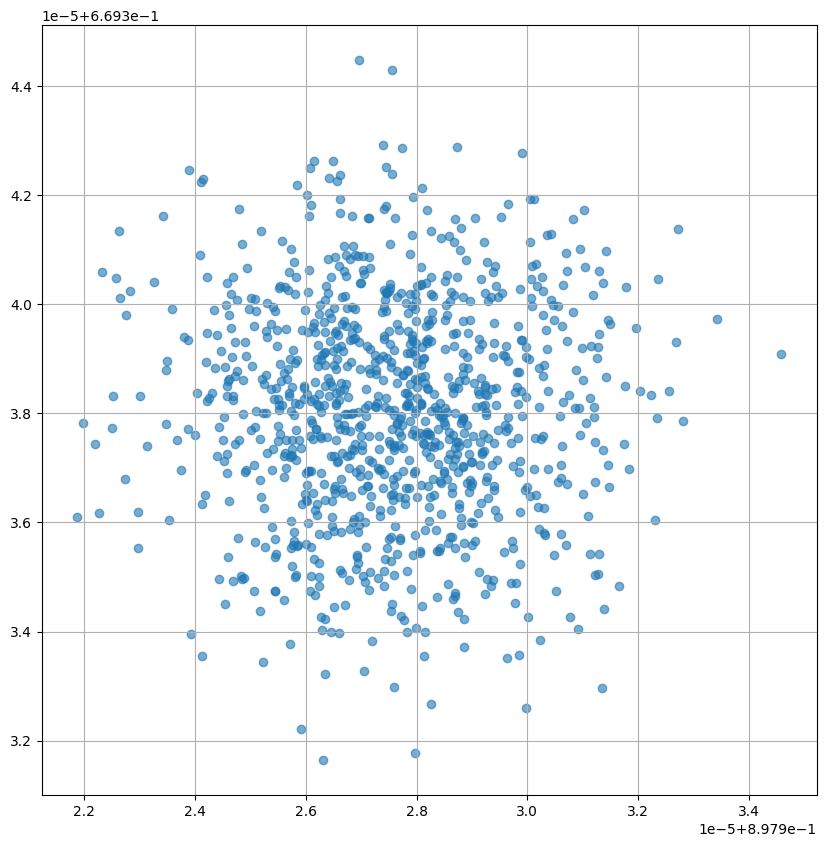

In [115]:
SAMPLE_CNT = 1000

lat, lon = 35.77080043514115, 51.447460106930826

samples =   [add_noise_to_coordinates(lat, lon, GPS_NOISE) for _ in range(SAMPLE_CNT)]

x, y = [mercator_projection(*i)[0] for i in samples], [mercator_projection(*i)[1] for i in samples]

plt.figure(figsize=(10, 10))
plt.scatter(x, y, alpha=0.6)
plt.grid(True)
plt.show()

In [116]:
create_kepler_compare_rides(GPS_TIME, [(lat, lon)], samples)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_0':    Latitude  Longitude                        Time
0   35.7708   51.44746  2024-01-08…

tmp = []

for loc in ride:
    for i in range(SAMPLE_CNT):
        tmp.append(add_noise_to_coordinates(*loc))

create_kepler_compare_rides(GPS_TIME, ride, tmp)

In [117]:
create_kepler_compare_rides(GPS_TIME, ride, [add_noise_to_coordinates(*loc) for loc in ride])

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_0':      Latitude  Longitude                        Time
0   35.779083  51.464298  2024-0…

## Uniform Distribution

In [118]:
def uniform_with_std_dev(std_dev):
    a = -np.sqrt(3) * std_dev
    b = np.sqrt(3) * std_dev

    return  np.random.uniform(a, b)

def add_uniform_noise_to_coordinates(lat, lon, std_dev=10):
    radius = 6_378_137.0
    
    std_dev_lat = std_dev / (2 * radius * np.pi) * 360

    std_dev_lon = std_dev / (2 * np.pi * (radius  * np.cos(np.radians(lat)))) * 360
    
    noisy_lat = lat + uniform_with_std_dev(std_dev_lat)
    noisy_lon = lon + uniform_with_std_dev(std_dev_lon)
    
    return noisy_lat, noisy_lon

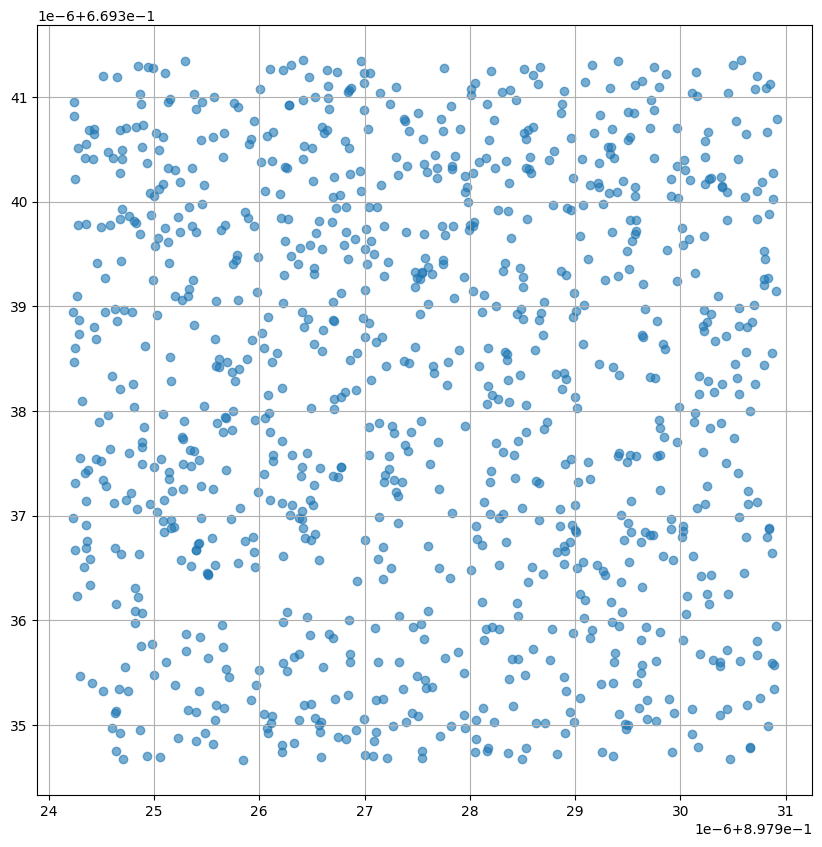

In [119]:
SAMPLE_CNT = 1000

lat, lon = 35.77080043514115, 51.447460106930826

samples =   [add_uniform_noise_to_coordinates(lat, lon, GPS_NOISE) for _ in range(SAMPLE_CNT)]

x, y = [mercator_projection(*i)[0] for i in samples], [mercator_projection(*i)[1] for i in samples]

plt.figure(figsize=(10, 10))
plt.scatter(x, y, alpha=0.6)
plt.grid(True)
plt.show()

In [120]:
create_kepler_compare_rides(GPS_TIME, [(lat, lon)], samples)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_0':    Latitude  Longitude                        Time
0   35.7708   51.44746  2024-01-08…

In [121]:
tmp = []

for loc in ride:
    for i in range(SAMPLE_CNT):
        tmp.append(add_uniform_noise_to_coordinates(*loc))

create_kepler_compare_rides(GPS_TIME, ride, tmp)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_0':      Latitude  Longitude                        Time
0   35.779083  51.464298  2024-0…

## Conclusion

**Explanation of my noise model:**
I will be using gaussian noise model on lat and lon because it looks just like google maps circular noise as said in the begining of notebook. uniform distrubation creates a square like distribution around the true position. Having the speed reflect in the gaussian standard devation could've made it better but I needed some data on how speed and noise corrolate and its effect on it. Because of random sources of noise and aggregation of them normal distribution is a better choice.

In [122]:
create_kepler_compare_rides(GPS_TIME, ride, [add_noise_to_coordinates(*loc) for loc in ride])

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_0':      Latitude  Longitude                        Time
0   35.779083  51.464298  2024-0…

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [123]:
def create_a_ride():
    tmp_start_node, tmp_end_node = [(row['lat'], row['lon']) for _, row in pasdaran_nodes.sample(2, replace=False).iterrows()]
    tmp_path = find_shotest_path(tmp_start_node, tmp_end_node, pasdaran_streets)

    return visualize_a_ride(RIDE_SPEED, GPS_TIME, path)

def create_noisy_ride_from_trip(trip, number_of_noisy_rides=20):
    ride = visualize_a_ride(RIDE_SPEED, GPS_TIME, path)
    noisy_rides = []
    for i in range(number_of_noisy_rides):
        noisy_rides.append(add_gps_noise(ride, GPS_NOISE))
    return noisy_rides

In [124]:
noisy_rides = create_noisy_ride_from_trip(path)

11.223068100757914
5.070996074710715
6.367499174313853
8.820534511707152
10.933066095488753
9.747606683769447
12.445002619016494
1.0134173551006658
12.592850757938962
9.535564992653821
10.439536190042272
10.981701990870514
11.717588994611607
11.004722993164243
11.734078408701215
10.215324591134525
12.193282619019444
10.678709633900034
12.853104465224328
14.242548107318852
8.317608917092617
14.53818136405195
14.393519852167396
14.510617366088868
13.856094812482004
10.858509291840955
11.741423674952433
14.814155613043825
10.042515293766009
3.4681367109050303


In [125]:
create_kepler_compare_rides(GPS_TIME, *noisy_rides)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_0':      Latitude  Longitude                        Time
0   35.778974  51.464309  2024-0…

# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

### Reasoning
Each street is state, (2 way streets count as 2). transision gets calculated by distance of 2 streets and emission get calculated by the distance of closest point on line to noisy point.
Inorder to save time we will filter nearby streets by gps time and ride speed

### Implemation of helper functions

In [126]:
SEGMENTATION_COUNT = 100

In [131]:
def create_segmentation_nodes_from_street(u_loc, v_loc, street_id, cnt):
    data = {
        "street_id": [street_id for i in range(cnt)],
        "lat": [u_loc[0]],
        "lon": [u_loc[1]]
    }
    diff = (np.array(v_loc) - np.array(u_loc)) / (cnt-1)
    for i in range(cnt-1):
        point = np.array(u_loc) + diff * (i+1)
        data['lat'].append(point[0])
        data['lon'].append(point[1])
    return pd.DataFrame(data)

In [132]:
def get_street_locs(street):
    return (street['u_lat'], street['u_lon']), (street['v_lat'], street['v_lon'])

In [133]:
def create_segmentation_nodes_from_streets_df(streets_df):
    street_nodes = []
    for street_id, street in streets_df.iterrows():
        street_nodes.append(create_segmentation_nodes_from_street(*get_street_locs(tmp_street), street_id , SEGMENTATION_COUNT))
    return pd.concat(street_nodes, ignore_index=True)

In [200]:
def get_loc_cartesian(lat, lon):
    radius = 6_378_137.0
    x = radius * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
    y = radius * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
    return x, y

In [755]:
from pyproj import Proj, Transformer
from shapely.geometry import LineString, Point
from geopy.distance import geodesic

proj_utm = Proj(proj='utm', zone=39, ellps='WGS84', preserve_units=False)
transformer = Transformer.from_proj(proj_utm, 'epsg:4326', always_xy=True)

def get_closest_point_in_street_to_noisy_loc(noisy_loc, street_u, street_v):
    x1, y1 = proj_utm(*street_u)
    x2, y2 = proj_utm(*street_v)
    x3, y3 = proj_utm(*noisy_loc)

    street_line = LineString([(x1, y1), (x2, y2)])
    noisy_point = Point(x3, y3)

    proj_dist = street_line.project(noisy_point)

    if proj_dist < 0:
        closest_point_coords = Point(x1, y1) 
    elif proj_dist > street_line.length:
        closest_point_coords = Point(x2, y2) 
    else:
        closest_point_coords = street_line.interpolate(proj_dist)

    closest_lat, closest_lon = transformer.transform(closest_point_coords.x, closest_point_coords.y)
    return closest_lat, closest_lon

def distance_noisy_loc_street(noisy_loc, street_u, street_v):
    closest_point = get_closest_point_in_street_to_noisy_loc(noisy_loc, street_u, street_v)
    return geodesic(closest_point, noisy_loc).meters

In [455]:
def get_noise_point_to_street_probabiliy(noisy_loc, street_locs, beta=1.0):
    distance = distance_noisy_loc_street(noisy_loc, *street_locs)
    return np.exp(-distance/beta) / beta

def get_noise_point_to_street_probability(noisy_loc, street_locs, beta=1.0):
    distance = distance_noisy_loc_street(noisy_loc, *street_locs)
    return np.exp(-distance/beta) / beta

In [205]:
def get_noise_point_to_real_probabiliy(noisy_loc, real_loc, beta=1.0):
    return np.exp(-haversine_distance(*noisy_loc, *real_loc)/beta) / beta

In [809]:
def get_consecutive_streets_probabiliy(street_1, street_2, streets_df):
    if street_1['v'] != street_2['u'] and street_1['street_id'] != street_2['street_id']:
        return get_noise_point_to_street_probabiliy(get_street_locs(street_1)[1], get_street_locs(street_2))
    return 0.7

In [685]:
def create_clean_street_df(dirty_street_df):
    tmp = dirty_street_df[dirty_street_df['oneway'] == 'no'].copy()
    tmp['u'], tmp['u_lat'], tmp['u_lon'], tmp['v'], tmp['v_lat'], tmp['v_lon'] = tmp['v'], tmp['v_lat'], tmp['v_lon'], tmp['u'], tmp['u_lat'], tmp['u_lon']
    tmp = pd.concat((tmp, dirty_street_df.copy()), ignore_index=True)
    return tmp.drop(columns=['oneway'])
    

### HMM model implemention

In [820]:
class HMM:
    
    def __init__(self, streets_df):
        self.clean_streets_df = create_clean_street_df(streets_df)
        self.beta = 1 
        self._create_trans()

    def _create_trans(self):
        num_streets = len(self.clean_streets_df)
        self.trans = np.zeros((num_streets, num_streets), dtype=np.float64)
        clean_streets = self.clean_streets_df.to_dict('records')  # Pre-fetch the rows
        gps_interval_distance = 1000

        for i, street_i in enumerate(clean_streets):
            for j, street_j in enumerate(clean_streets):
                if haversine_distance(*get_street_locs(street_i)[1], *get_street_locs(street_j)[0]) > gps_interval_distance:
                    continue
                self.trans[i,j] = get_consecutive_streets_probability(street_i, street_j)
        print("created trans")

    def _get_emission_matrix(self, noisy_ride, beta):
        num_streets = len(self.clean_streets_df)
        num_points = len(noisy_ride)
        mat = np.zeros((num_streets, num_points), dtype=np.float64)
        for i, street_i in self.clean_streets_df.iterrows():
            mat[i] = [get_noise_point_to_street_probability(point, get_street_locs(street_i), beta) for point in noisy_ride]
        return mat
    
    def _get_most_probable_streets(self, noisy_ride, beta, gps_time, ride_speed):

        prob = self._get_emission_matrix(noisy_ride, beta)
        num_streets = len(self.clean_streets_df)
        num_points = len(noisy_ride)
        dp = np.zeros((len(noisy_ride), len(self.clean_streets_df)), dtype=np.float64)
        par = np.full((len(noisy_ride), len(self.clean_streets_df)), -1, dtype=np.int32)
        for i, street in self.clean_streets_df.iterrows():
            dp[0, i] = prob[i, 0]
        dp[0, :] /= dp[0, :].sum()

        for i in range(1, len(noisy_ride)):
            for j, street in self.clean_streets_df.iterrows():
                tmp = self.trans[j, :] * dp[i-1, :]
                par[i, j] = np.argmax(tmp)
                dp[i, j] = prob[j, i] * tmp[par[i, j]]
            dp[i, :] /= dp[0, :].sum()

        i = np.argmax(dp[-1, :])
        res = [0 for _ in range(len(noisy_ride))]
        idx = len(noisy_ride) - 1
        while idx >= 0:
            res[idx] = i
            i = par[idx, i]
            idx -= 1
        return res

    
    def _get_noisy_ride_most_probable_locs_by_streets(self, noisy_ride, ride_streets):
        ride_streets_df = self.clean_streets_df.iloc[ride_streets]
        return [get_closest_point_in_street_to_noisy_loc(noisy_point, *get_street_locs(street)) for (_, street), noisy_point in zip(ride_streets_df.iterrows(), noisy_ride)]

    def denoise(self, noisy_ride, gps_time, ride_speed):
        streets = self._get_most_probable_streets(noisy_ride, self.beta, gps_time, ride_speed)
        return self._get_noisy_ride_most_probable_locs_by_streets(noisy_ride, streets)

In [821]:
sample_ride = noisy_rides[1]

In [822]:
hmm = HMM(pasdaran_streets)

created trans


In [823]:

hmm.beta=10
tmp = hmm.denoise(sample_ride, GPS_TIME, RIDE_SPEED)
tmp

[(35.77883529663086, 51.46432876586914),
 (35.778617858886726, 51.46356964111328),
 (35.77846864973872, 51.464321838991765),
 (35.77805660623488, 51.46429758631544),
 (35.77689621588003, 51.46391076275287),
 (35.77671307539539, 51.46343138409271),
 (35.77704620361329, 51.462120056152344),
 (35.77739334106445, 51.4607162475586),
 (35.7769660949707, 51.45964431762695),
 (35.7769660949707, 51.45964431762695),
 (35.777099609375, 51.459259033203125),
 (35.77722167968749, 51.45889663696289),
 (35.77781295776367, 51.45696258544921),
 (35.77751778840113, 51.456181402250394),
 (35.77652740478517, 51.455753326416016),
 (35.776503993488696, 51.45543183768541),
 (35.77670669555664, 51.454216003417976),
 (35.776911674708344, 51.45391277004056),
 (35.77661514282227, 51.45381164550781),
 (35.777008056640625, 51.453216552734375),
 (35.77742965273384, 51.45175808028446),
 (35.77746149884967, 51.45121428408569),
 (35.77818450489745, 51.45153601670198),
 (35.77784147891085, 51.450364331550475),
 (35.7781

In [824]:
tmp

[(35.77883529663086, 51.46432876586914),
 (35.778617858886726, 51.46356964111328),
 (35.77846864973872, 51.464321838991765),
 (35.77805660623488, 51.46429758631544),
 (35.77689621588003, 51.46391076275287),
 (35.77671307539539, 51.46343138409271),
 (35.77704620361329, 51.462120056152344),
 (35.77739334106445, 51.4607162475586),
 (35.7769660949707, 51.45964431762695),
 (35.7769660949707, 51.45964431762695),
 (35.777099609375, 51.459259033203125),
 (35.77722167968749, 51.45889663696289),
 (35.77781295776367, 51.45696258544921),
 (35.77751778840113, 51.456181402250394),
 (35.77652740478517, 51.455753326416016),
 (35.776503993488696, 51.45543183768541),
 (35.77670669555664, 51.454216003417976),
 (35.776911674708344, 51.45391277004056),
 (35.77661514282227, 51.45381164550781),
 (35.777008056640625, 51.453216552734375),
 (35.77742965273384, 51.45175808028446),
 (35.77746149884967, 51.45121428408569),
 (35.77818450489745, 51.45153601670198),
 (35.77784147891085, 51.450364331550475),
 (35.7781

In [825]:
create_kepler_compare_rides(GPS_TIME, sample_ride, tmp, ride)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_0':      Latitude  Longitude                        Time
0   35.779052  51.464433  2024-0…

Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [701]:
from haversine import haversine
from tqdm import tqdm

def mean_haversine_distance(denoised_points, original_points):
    return np.array([haversine(denoised_point, original_point) for denoised_point, original_point in zip(denoised_points, original_points)]).mean()

test_dataset_noisy = pd.read_csv("noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("original_test_dataset.csv")

test_dataset_original.head()

Unnamed: 0  trip_id  index      source  destination        lat        lon  \
0           0        0      0  4429680702   4695666788  35.771816  51.461178   
1           0        0      1  4429680702   4695666788  35.771458  51.460865   
2           0        0      2  4429680702   4695666788  35.770760  51.460239   
3           0        0      3  4429680702   4695666788  35.770027  51.459633   
4           0        0      4  4429680702   4695666788  35.769318  51.459030   

   ride_speed  ride_gps_time  
0     0.00096          0.466  
1     0.00096          0.466  
2     0.00096          0.466  
3     0.00096          0.466  
4     0.00096          0.466

In [702]:
test_dataset_noisy.head()

Unnamed: 0  trip_id  index      source  destination        lat        lon  \
0           0        0      0  4429680702   4695666788  35.771917  51.461279   
1           0        0      1  4429680702   4695666788  35.771399  51.460806   
2           0        0      2  4429680702   4695666788  35.770759  51.460239   
3           0        0      3  4429680702   4695666788  35.769997  51.459603   
4           0        0      4  4429680702   4695666788  35.769289  51.459002   

   ride_speed  ride_gps_time  
0     0.00096          0.466  
1     0.00096          0.466  
2     0.00096          0.466  
3     0.00096          0.466  
4     0.00096          0.466

In [738]:
def get_locs_from_df(df):
    return [(lat, lon) for lat, lon in zip(df['lat'], df['lon'])]
def get_ride_info(df):
    return df.iloc[0]['ride_gps_time'], df.iloc[0]['ride_speed'] 
def create_denoised_df(test_df, denoised, trip_id):
    test_df = test_df.copy()
    test_df['lat'] = [i[0] for i in denoised]
    test_df['lon'] = [i[1] for i in denoised] 
    test_df['trip_id'] = [trip_id for i in range(len(denoised))]
    return test_df

In [782]:
hmm.beta = 0.5
mean_haversine_distances = []
denoised_dfs = []
for (trip_id, test), (_, original) in zip(test_dataset_noisy.groupby('trip_id'), test_dataset_original.groupby('trip_id')):
    denoised = hmm.denoise(get_locs_from_df(test), *get_ride_info(test))
    denoised_dfs.append(create_denoised_df(test, denoised, trip_id))
    noisy_points = get_locs_from_df(test)
    original_points = get_locs_from_df(original)
    mean_haversine_distances.append(mean_haversine_distance(denoised, original_points))
    print(mean_haversine_distances)


created trans
[0.005680775678974494]
created trans
[0.005680775678974494, 0.011081665337372981]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604133588478]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604133588478, 0.019961026322794014]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604133588478, 0.019961026322794014, 0.002596357983064464]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604133588478, 0.019961026322794014, 0.002596357983064464, 0.005769252657883663]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604133588478, 0.019961026322794014, 0.002596357983064464, 0.005769252657883663, 0.005324067435903466]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604133588478, 0.019961026322794014, 0.002596357983064464, 0.005769252657883663, 0.005324067435903466, 0.0197037740633388]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604133588478, 0.0199610

/var/folders/0t/7cqgng3s4053pmpmrs4smm500000gn/T/ipykernel_23659/3222259781.py:45: RuntimeWarning: invalid value encountered in divide
  dp[i, :] /= dp[i, :].sum()


[0.005680775678974494, 0.011081665337372981, 0.007031604133588478, 0.019961026322794014, 0.002596357983064464, 0.005769252657883663, 0.005324067435903466, 0.0197037740633388, 0.0103678450242876, 0.0030679103237288433, 0.0379174243394676, 0.00566432261660345, 1.8452133768793484]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604133588478, 0.019961026322794014, 0.002596357983064464, 0.005769252657883663, 0.005324067435903466, 0.0197037740633388, 0.0103678450242876, 0.0030679103237288433, 0.0379174243394676, 0.00566432261660345, 1.8452133768793484, 0.005668886471363119]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604133588478, 0.019961026322794014, 0.002596357983064464, 0.005769252657883663, 0.005324067435903466, 0.0197037740633388, 0.0103678450242876, 0.0030679103237288433, 0.0379174243394676, 0.00566432261660345, 1.8452133768793484, 0.005668886471363119, 0.00690688441754174]
created trans
[0.005680775678974494, 0.011081665337372981, 0.007031604

In [763]:
create_kepler_compare_rides(GPS_TIME, denoised, original_points, noisy_points)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_0':      Latitude  Longitude                        Time
0   35.771926  51.461275  2024-0…

**How to submit**: You should submit your notebook and the `denoised_test_dataset.csv` file. Your codes are verified based on the "Mean haversine distance" value that your code gets and the `denoised_test_dataset.csv`. Also, note that for the **shortest path** section, you should have submitted the `.py` file, containing the `def find_shotest_path(start_node, end_node, graph)` function (and all of necessary imports) on quera. Your code will be verified based on the correctness of the shortest path that you find. So, you should submit these in total:
1. `STUDENT_NUMBER_Phase1.ipynb` or `.zip` file containing your notebook and the `denoised_test_dataset.csv` file.
2. `STUDENT_NUMBER_Phase1.py` file containing the `find_shortest_path` function. (Also submit this to the related section in quera)
3. Printed out Average Haversine Distance in the last cell of notebook. (This should be of order $10^{-3}$)

In [775]:
denoised_df = pd.concat(denoised_dfs, ignore_index=True)

denoised_df.to_csv('denoised_test_dataset.csv')

In [783]:
print(np.array(mean_haversine_distances).mean())

0.10648740619055674
